In [18]:
import numpy as np
import matplotlib.pyplot as plt
import joblib
import control as ctr

def upload_file(data_folder, filename,number_of_tags):
    """
    upload SPAD binary file and retrieve timestamps and addreses of each tag in two separate tables 
    """
    global a
    fh =np.fromfile(data_folder+filename,dtype =np.uint8)
    a=number_of_tags
    arr = np.unpackbits(fh)
    arr2 = arr.reshape(4*a, 8)
    arr3 = np.array(arr2.T)
    arr4 = np.array(np.flipud(arr3))
    arr5 = np.array(arr4.reshape(32, a))
    arr2a = arr.reshape(4*a, 8)
    arr4a = np.array(np.fliplr(arr2a))
    arr5a = np.array(arr4a.reshape(a, 32))
    arr6a = np.array(np.fliplr(arr5a))
    addr = np.array(np.fliplr(arr6a[:,1:6]))
    timestamp = np.array(np.fliplr(arr6a[:,6:]))
    val_addr = np.packbits(addr,axis=1,bitorder='little')
    val_timestamp = np.packbits(timestamp,axis=1,bitorder='little')
    val_timestamps = val_timestamp[:,0]+2**8*val_timestamp[:,1]+2**16*val_timestamp[:,2]+\
                    2**24*val_timestamp[:,3]
    return(val_addr,val_timestamps)
def detector_intensity(val_addr):
    """
    Check intensity of each detector and triggers(position 23 and 24 in return table)
    """
    return(np.unique(val_addr, return_counts=True)[1])
def time_unwrap(val_timestamps):
    """
    Unwrap timestamps into one nondecresing series 
    """
    val_time =val_timestamps.astype('int64')
    for i in range(a-1):
        if val_addr[i+1]>25:      #replacing trigger number with time of previous count
            val_time[i+1]=val_time[i]
        if val_time[i+1]-val_time[i]<-1*2**25:
            val_time[i+1:]+=2**26
    return(val_time)
def histogram_creation(val_addr,val_timestamps,time_range):
    """
    Creates g2 correlation histogram
    middle row(position time_range)-tags in the same time
    time_range-maximum registered tag difference
    
    """
    hist = np.zeros((23,23,2*time_range+1))
    for i in range(a-1):
        b=1    
        diff = val_time[i+b]-val_time[i]

        while diff<=time_range and diff>=0:

            hist[val_addr[i],val_addr[i+b],time_range+diff]+=1
            hist[val_addr[i+b],val_addr[i],time_range-diff]+=1
            b+=1
            try:
                diff = val_time[i+b]-val_time[i]
            except:
                break
    return(hist)
def calc_correction(mode='create', channels=23,hist=[],counts_detec=[],filename=''):
    """
    mode create - calculate correction parameters and save it in pkl file
    mode upload - upload correction parameters from pkl file
    """
    if mode =='create':
        correction = np. zeros((channels,channels))
        correction_extra  = np. zeros((18,3))
        for i in range(channels):
            for j in range(channels):
                if i!=j:
                    correction[i,j] =(hist[i,j,100]- (hist[i,j,180]/2.+hist[i,j,20]/2.))/(1.*(counts_detec[i]+counts_detec[j]))
                if i+5==j:

                    correction_extra [i,0] =(hist[i,j,101]- (hist[i,j,181]/2.+hist[i,j,21]/2.))/(1.*(counts_detec[i]))
                    correction_extra [i,1] =(hist[i,j,102]- (hist[i,j,182]/2.+hist[i,j,22]/2.))/(1.*(counts_detec[i]))
                    correction_extra [i,2] =(hist[i,j,103]- (hist[i,j,183]/2.+hist[i,j,23]/2.))/(1.*(counts_detec[i]))
        joblib.dump((correction,correction_extra),filename)
        return(correction,correction_extra)
    elif mode == 'upload':
        (correction,correction_extra) =joblib.load(filename)
        return(correction,correction_extra)
def histogram_correction(hist,correction,correction_extra,counts_detec,middle_row):
    """
    Correct histograms using near 0 delay correction parameters
    
    """
    hist_corrected = np.copy(hist)
    for i in range(23):
        for j in range(23):
            if i!=j:
                hist_corrected[i,j,middle_row] -=(counts_detec[i]+counts_detec[j])*correction[i,j]
            if i+5==j:
                hist_corrected[i,j,middle_row+1] -=(counts_detec[i])*correction_extra[i,0]
                hist_corrected[j,i,middle_row-1] -=(counts_detec[i])*correction_extra[i,0]            
                hist_corrected[i,j,middle_row+2] -=(counts_detec[i])*correction_extra[i,1]
                hist_corrected[j,i,middle_row-2] -=(counts_detec[i])*correction_extra[i,1]
                hist_corrected[i,j,middle_row+3] -=(counts_detec[i])*correction_extra[i,2]
                hist_corrected[j,i,middle_row-3] -=(counts_detec[i])*correction_extra[i,2]
    return(hist_corrected)

def scan_points(val_addr,x_points,y_points):
    """
    finding triggers inside tags list and return list of all tags as numpy array
    """
    channels=23
    pixels = np.zeros((y_points,x_points))
    scan_hist = np.zeros((y_points,x_points,channels)) 
    lines = np.where(val_addr==31)[0]

    if lines.shape ==(0,):
        lines = np.array([0,a])
    else:
        lines =np.concatenate((lines,[a]))
    for i in range(y_points):
        part = val_addr[lines[i]:lines[i+1]]
        pix = np.concatenate(([0],np.where(part==30)[0],[lines[i+1]-lines[i]]))
        print(pix)
        if i%2==0:
            pixels[i] = lines[i] + pix[:-1]
        else:
            pixels[i] = lines[i] + np.flip(pix[:-1])
    return(pixels,lines)


def counts_scan(val_addr,val_timestamps,pixels,dwell_time):
    """
    return number of counts of every detector/every pixel in desired dwell time
    dwell time in miliseconds
    """
    dwell_time = int(dwell_time * 1e5)
    x,y = pixels.shape
    counts = np.zeros((x,y,23))
    
    for i in range(x):
        for j in range(y):
            if i%2 ==0:
                delta= 1
                while val_timestamps[int(pixels[i,j]+delta)]- val_timestamps[int(pixels[i,j])]<dwell_time:
                    if val_addr[int(pixels[i,j]+delta)]<25:
                        counts[i,j,val_addr[int(pixels[i,j]+delta)]] += 1
                        delta += 1
            else:
                delta= 1

                while val_timestamps[int(pixels[i,y-1-j]+delta)]- val_timestamps[int(pixels[i,y-1-j])]<dwell_time:
                    if val_addr[int(pixels[i,y-1-j]+delta)]<25:
                        counts[i,y-1-j,val_addr[int(pixels[i,y-1-j]+delta)]] += 1
                        delta += 1

    return(counts)

def counts_scan_binned(val_addr,val_timestamps,pixels,dwell_time,bin_time):
    """
    return number of counts of every detector/every pixel in desired dwell time presented in time series
    """
    x,y = pixels.shape
    counts = np.zeros((1,np.ceil(dwell_time/bin_time),x,y,23))
    for i in range(x):
        for j in range(y):
            delta= 0
            try:
                while val_timestamps[pixels[i,j]+delta]- val_timestamps[pixels[i,j]]<dwell_time:
                    bin_number = np.floor(val_timestamps[pixels[i,j]+delta]- val_timestamps[pixels[i,j]])
                    counts[0,bin_number,i,j,val_addr[pixels[i,j]+delta]] += 1
                    delta += 1
            except:
                pass
    return(counts)


def counts_scan_binned_add(counts,val_addr,val_timestamps,pixels,dwell_time,bin_time):
    """
    return number of counts of every detector/every pixel in desired dwell time presented in time series
    Add result to existing counts table
    """

    counts1 = np.zeros(1,(np.ceil(dwell_time/bin_time),x,y,23))
    for i in range(x):
        for j in range(y):
            delta= 0
            while val_timestamps[pixels[i,j]+delta]- val_timestamps[pixels[i,j]]<dwell_time:
                bin_number = np.floor(val_timestamps[pixels[i,j]+delta]- val_timestamps[pixels[i,j]])
                counts1[0,bin_number,i,j,val_addr[pixels[i,j]+delta]] += 1
                delta += 1
    counts = np.concatenate((counts,counts),axis = 0)
    return(counts)        
        
def histogram_plot(val_addr):
    """
    Create a detector heat map for certain range of tags
    """
    pos = np.zeros((val_addr.shape[0],2))
    for i in range(val_addr.shape[0]):
        if i%1e6==0:
            print(i)
        temp=val_addr[i]
        if temp<25:
            if temp<=4:
                pos[i,0]=np.sqrt(3)
                pos[i,1] = temp-2.
            elif temp<=8:
                pos[i,0]=np.sqrt(3)/2.
                pos[i,1] = temp-6.5            
            elif temp<=13:
                pos[i,0]=0
                pos[i,1] = temp-11. 
            elif temp<=17:
                pos[i,0]=-np.sqrt(3)/2.
                pos[i,1] = temp-15.5  
            elif temp<=23:
                pos[i,0]=-np.sqrt(3)
                pos[i,1] = temp-20.
    plt.hexbin(pos[:,1],pos[:,0],gridsize=(4,2))
    plt.colorbar()
    plt.show()
    return(pos)
    

0
1000000
2000000


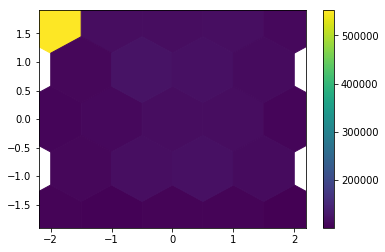

In [21]:
# Processing single pixel data for G2 measurement
#a=20000000                          #number of tags set on SPAD(require before running all functions)
val_addr, val_timestamps  = upload_file(data_folder="./2020.02/07/",filename = "t31",number_of_tags=20000000)
counts_detec=detector_intensity(val_addr)
val_time=time_unwrap(val_timestamps)
correction,correction_extra=calc_correction(mode='upload', channels=23,hist=[],counts_detec=[],filename='correction_parameters_laser.pkl')
hist =  histogram_creation(val_addr,val_timestamps,time_range =100)
hist_corrected = histogram_correction(hist,correction,correction_extra,counts_detec,100)
pos = histogram_plot(val_addr)

In [19]:
#intensity scan analysis
#final data- counts intensity value of each pixel in every scan point
# format :(x,y,detector)
nanoSPAD_X=10
nanoSPAD_Y=10
val_addr, val_timestamps  = upload_file(data_folder="./2020.02/07/",filename = "t5",number_of_tags=20000000)
counts_detec=detector_intensity(val_addr)
val_time=time_unwrap(val_timestamps)
points,lines = scan_points(val_addr=val_addr,x_points=nanoSPAD_X+1,y_points = nanoSPAD_Y)
counts = counts_scan(val_addr,val_time,points,dwell_time = 40)

[      0  161085  280060  390669  504517  631284  768207  911922 1038508
 1154699 1246847 1330050]
[      0   73363  165324  283113  416801  566274  688998  818171  942941
 1078012 1238541 1426375]
[      0  171240  318594  476346  612080  744135  890700 1026827 1151334
 1256517 1332826 1399611]
[      0   80093  180897  301394  429007  557235  685727  825437  979037
 1160221 1336659 1503416]
[      0  162148  338976  499150  640522  785911  913288 1051044 1170978
 1295697 1400768 1487439]
[      0   87342  199025  328437  460826  585037  704067  823614  964224
 1124935 1289119 1449815]
[      0  164510  326834  474015  597754  706553  821200  957213 1089363
 1219324 1317249 1387584]
[      0   87270  206431  339177  495216  629200  744304  871318 1028127
 1186875 1342968 1468666]
[      0  127587  289095  467086  619278  754755  872083 1001181 1139370
 1268889 1387788 1494247]
[      0  135088  274558  422420  559601  688101  827518  971307 1146527
 1332746 1501370 4977383]


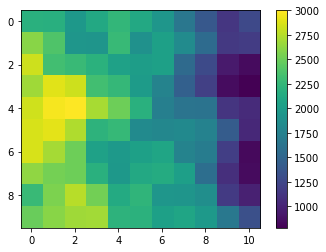

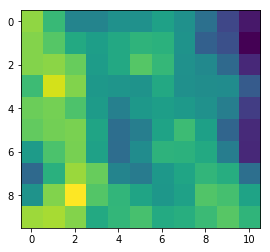

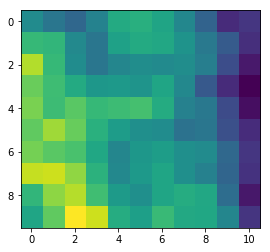

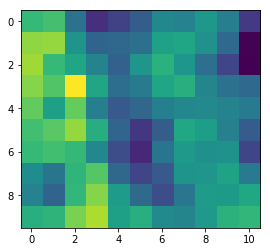

[[2190. 2183. 1963. 2122. 2248. 2117. 1944. 1658. 1392. 1128. 1272.]
 [2610. 2391. 1950. 1942. 2275. 1900. 2044. 1849. 1557. 1148. 1177.]
 [2831. 2330. 2284. 2199. 2050. 2018. 2041. 1549. 1283.  942.  844.]
 [2684. 2898. 2835. 2327. 2260. 1998. 1776. 1465. 1202.  858.  781.]
 [2839. 2967. 3001. 2709. 2511. 2188. 1740. 1632. 1624. 1127. 1052.]
 [2869. 2909. 2739. 2220. 2269. 1847. 1810. 1837. 1761. 1423. 1041.]
 [2869. 2706. 2513. 2048. 1978. 2039. 2089. 1777. 1713. 1196.  836.]
 [2629. 2541. 2507. 2186. 1964. 2124. 2144. 2034. 1585. 1079.  842.]
 [2287. 2561. 2765. 2529. 2141. 2235. 1948. 1942. 1876. 1159.  981.]
 [2497. 2607. 2687. 2693. 2219. 2207. 2047. 2086. 1978. 1667. 1320.]]


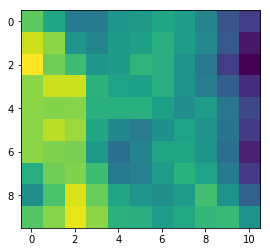

In [21]:
#visualization of 
plt.imshow(counts[:,:,1])
plt.colorbar()
p
plt.imshow(np.sum(counts[:,:,:],axis=2))

In [34]:
#min dead time calculation(VQ=0.85V-approved by Michel to increase VQ until dead time is equal 50 ns)
#recommended in manual VQ= 0.75(left power supply ch 3)
for i in range(23):
    print(i,10*min(np.abs(100-np.where(hist_corrected[i,i,:]>0)[0])),'ns')

NameError: name 'hist_corrected' is not defined

STEP BY STEP CELLS


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import joblib
data_folder = "./2020.02/07/"
filename = "t5"
a=20000000
#fh = open(data_folder+filename, "rb")
fh =np.fromfile(data_folder+filename,dtype =np.uint8)
#ch = fh.read()
arr = np.unpackbits(fh)
arr2 = arr.reshape(4*a, 8)
arr3 = np.array(arr2.T)
arr4 = np.array(np.flipud(arr3))
arr5 = np.array(arr4.reshape(32, a))
arr2a = arr.reshape(4*a, 8)
arr4a = np.array(np.fliplr(arr2a))
arr5a = np.array(arr4a.reshape(a, 32))
arr6a = np.array(np.fliplr(arr5a))
addr = np.array(np.fliplr(arr6a[:,1:6]))
timestamp = np.array(np.fliplr(arr6a[:,6:]))
val_addr = np.packbits(addr,axis=1,bitorder='little')
val_timestamp = np.packbits(timestamp,axis=1,bitorder='little')
val_timestamps = val_timestamp[:,0]+2**8*val_timestamp[:,1]+2**16*val_timestamp[:,2]+\
                2**24*val_timestamp[:,3]

31
31
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 30, 31], dtype=uint8), array([ 546196,  610275,  796745,  756464,  585346,  689684,  992243,
       1194926,  976721,  588027, 1036427, 1420288, 1330076,  896156,
        720413, 1117538, 1260069, 1004400,  477225,  679427,  858245,
        823691,  639308,     100,      10], dtype=int64))


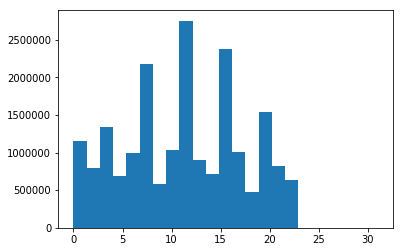

In [25]:
# histogram of channels (chan:0-22-detectors, 30-pixel trigger,31)

print(np.amax(val_addr))
print(val_addr.max())

plt.hist(val_addr,bins =23)
plt.plot()
counts_detec = np.unique(val_addr, return_counts=True)[1]
print(np.unique(val_addr, return_counts=True))

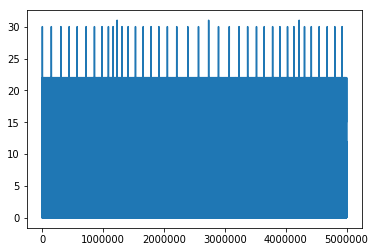

In [30]:
plt.plot(val_addr[5000000:10000000])


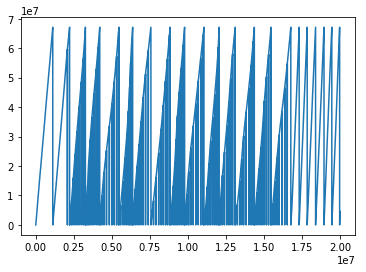

21


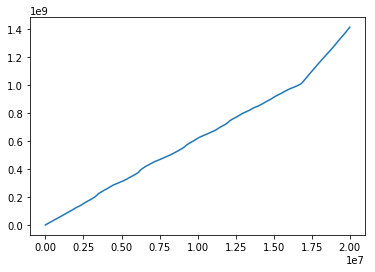

In [27]:
#unwraping time
plt.plot(val_timestamps[:])
plt.show()
c=0
val_time =val_timestamps.astype('int64')
for i in range(a-1):
    if val_addr[i+1]>25:      #replacing trigger number with time of previous count
        val_time[i+1]=val_time[i]
    if val_time[i+1]-val_time[i]<-1*2**25:
        val_time[i+1:]+=2**26
        c+=1
print(c)
plt.plot(val_time)
plt.show()      

In [45]:
max(val_time)/1e8

50.52535439

In [ ]:
#Crosstalk(G2) occurance map
hist = np.zeros((23,23,201))
for i in range(a-1):
    b=1    
    diff = val_time[i+b]-val_time[i]
    
    while diff<=100 and diff>=0:
        if val_addr[i]<25 and val_addr[i+1]<25:
            hist[val_addr[i],val_addr[i+b],100+diff]+=1
            hist[val_addr[i+b],val_addr[i],100-diff]+=1
            b+=1
            try:
                diff = val_time[i+b]-val_time[i]
            except:
                break


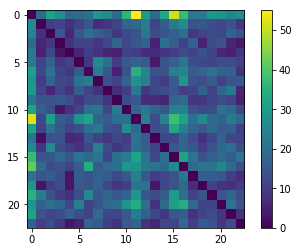

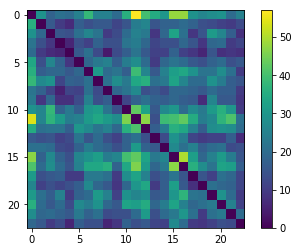

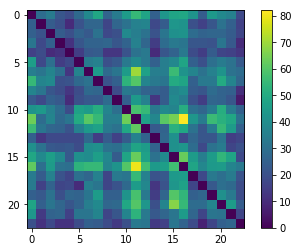

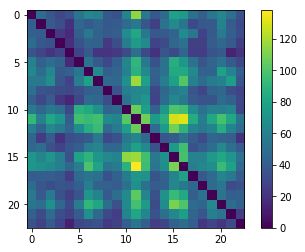

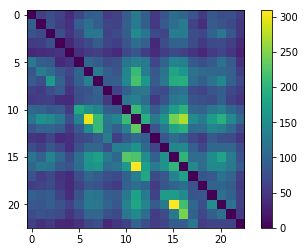

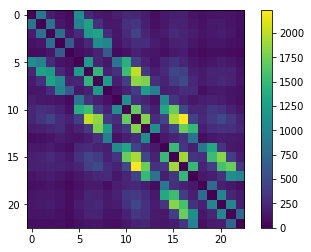

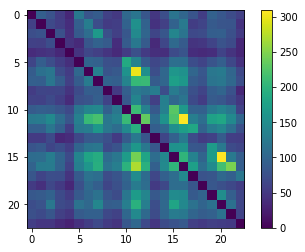

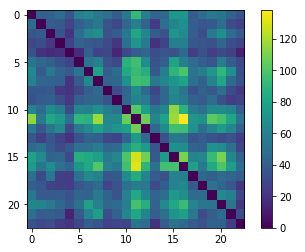

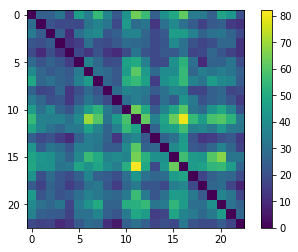

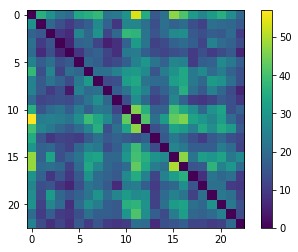

In [7]:
#G2 plot
for i in range(10):
    x=95+i
    plt.imshow((hist[:,:,x]))
    plt.colorbar()
    plt.show()


[13. 17. 16. 29. 61. 82. 53. 43. 17. 11.]


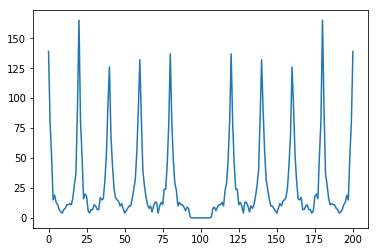

In [8]:
plt.plot(hist[17,17,:])
print(hist[17,22,115:125])

In [638]:
# (G2 correction coefficient)
correction = np. zeros((channels,channels))
correction_extra  = np. zeros((18,3))
for i in range(channels):
    for j in range(channels):
        if i!=j:
            correction[i,j] =(hist[i,j,100]- (np.average(hist[i,j,175:200])/2.+np.average(hist[i,j,:25])/2.))/(1.*(counts_detec[i]+counts_detec[j]))
        if i+5==j:
            print((i,j),hist[i,j,102],(np.average(hist[i,j,175:200]),np.average(hist[i,j,:25])))
            print((hist[i,j,102]- (np.average(hist[i,j,175:200])/2.+np.average(hist[i,j,:25])/2.))/(1.*(counts_detec[i])))
            print((counts_detec[i])*correction_extra[i,0])
            correction_extra [i,0] =(hist[i,j,101]- (np.average(hist[i,j,175:200])/2.+np.average(hist[i,j,:25])/2.))/(1.*(counts_detec[i]))
            correction_extra [i,1] =(hist[i,j,102]- (np.average(hist[i,j,175:200])/2.+np.average(hist[i,j,:25])/2.))/(1.*(counts_detec[i]))
            correction_extra [i,2] =(hist[i,j,103]- (np.average(hist[i,j,175:200])/2.+np.average(hist[i,j,:25])/2.))/(1.*(counts_detec[i]))
#joblib.dump((correction,correction_extra),'correction_parameters.pkl')        

(0, 5) 99.0 (61.2, 65.6)
8.272913180888641e-05
0.0
(1, 6) 89.0 (84.04, 123.4)
-3.428574090507834e-05
0.0
(2, 7) 124.0 (255.76, 420.48)
-0.0004893455585925716
0.0
(3, 8) 86.0 (115.48, 168.88)
-0.0001309084130442381
0.0
(4, 9) 24.0 (43.12, 55.2)
-0.00011204332104241257
0.0
(5, 10) 157.0 (270.52, 441.56)
-0.00043458705059847415
0.0
(6, 11) 226.0 (548.2, 953.28)
-0.0007863877028948911
0.0
(7, 12) 312.0 (1094.4, 2017.76)
-0.0005969055030764566
0.0
(8, 13) 109.0 (104.12, 159.48)
-2.5060370212012942e-05
0.0
(9, 14) 117.0 (258.88, 428.32)
-0.00034957051883299605
0.0
(10, 15) 335.0 (998.52, 1801.96)
-0.0005065573700331114
0.0
(11, 16) 395.0 (567.52, 988.72)
-0.00012766908939802052
0.0
(12, 17) 235.0 (202.64, 319.24)
-1.3234633106276552e-05
0.0
(13, 18) 18.0 (37.36, 51.84)
-6.688727733577414e-05
0.0
(14, 19) 253.0 (164.36, 263.56)
2.7352286094823588e-05
0.0
(15, 20) 236.0 (192.04, 307.8)
-7.929812048643026e-06
0.0
(16, 21) 122.0 (68.16, 102.76)
5.2855865786024865e-05
0.0
(17, 22) 49.0 (14.64, 16

In [17]:
# (G2 correction coefficient for laser)
correction = np. zeros((23,23))
correction_extra  = np. zeros((18,3))
for i in range(23):
    for j in range(23):
        if i!=j:
            correction[i,j] =(hist[i,j,100]- (hist[i,j,180]/2.+hist[i,j,20]/2.))/(1.*(counts_detec[i]+counts_detec[j]))
        if i+5==j:

            correction_extra [i,0] =(hist[i,j,101]- (hist[i,j,181]/2.+hist[i,j,21]/2.))/(1.*(counts_detec[i]))
            correction_extra [i,1] =(hist[i,j,102]- (hist[i,j,182]/2.+hist[i,j,22]/2.))/(1.*(counts_detec[i]))
            correction_extra [i,2] =(hist[i,j,103]- (hist[i,j,183]/2.+hist[i,j,23]/2.))/(1.*(counts_detec[i]))
joblib.dump((correction,correction_extra),'correction_parameters_laser.pkl')       

['correction_parameters_laser.pkl']

In [9]:
(correction,correction_extra)= joblib.load('correction_parameters_laser.pkl')

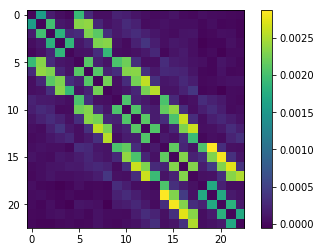

In [655]:
#calculation of first neighbor average coefficient
plt.imshow(correction)
plt.colorbar()
plt.show()
first_nei_sum_one  = np.concatenate((np.diag(correction,k=1)[:4],np.diag(correction,k=1)[5:8],\
                            np.diag(correction,k=1)[9:13],np.diag(correction,k=1)[14:17],\
                            np.diag(correction,k=1)[18:]))
first_nei_sum_four = np.concatenate((np.diag(correction,k=1)[1:9],np.diag(correction,k=1)[10:-1]))
first_nei_sum_five = np.concatenate((np.diag(correction,k=1)[:4],np.diag(correction,k=1)[5:13],\
                            np.diag(correction,k=1)[-4:]))
first_nei = np.concatenate((first_nei_sum_five,first_nei_sum_four,first_nei_sum_one))

In [468]:
print(np.average(first_nei),np.std(first_nei)) # first neighbor mean coefficitent and standard deviation

0.0017571848671031499 0.0006463129355437507


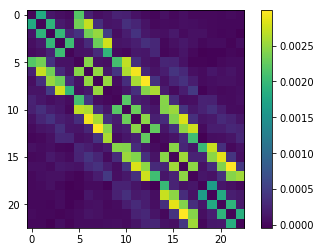

In [18]:
#Correcting coefficient
plt.imshow((correction[:,:]))
plt.colorbar()
plt.show()

hist_corrected = np.copy(hist)
for i in range(23):
    for j in range(23):
        if i!=j:
            hist_corrected[i,j,100] -=(counts_detec[i]+counts_detec[j])*correction[i,j]
        if i+5==j:
            hist_corrected[i,j,101] -=(counts_detec[i])*correction_extra[i,0]
            hist_corrected[j,i,99] -=(counts_detec[i])*correction_extra[i,0]            
            hist_corrected[i,j,102] -=(counts_detec[i])*correction_extra[i,1]
            hist_corrected[j,i,98] -=(counts_detec[i])*correction_extra[i,1]
            hist_corrected[i,j,103] -=(counts_detec[i])*correction_extra[i,2]
            hist_corrected[j,i,97] -=(counts_detec[i])*correction_extra[i,2]

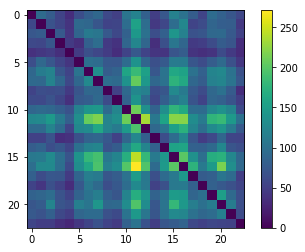

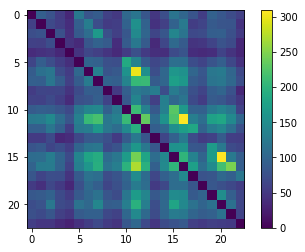

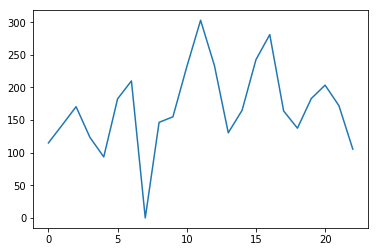

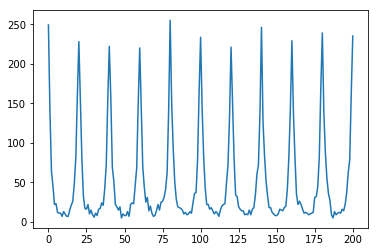

In [19]:
plt.imshow((hist_corrected[:,:,101]))
plt.colorbar()
plt.show()
plt.imshow((hist[:,:,101]))
plt.colorbar()
plt.show()


plt.plot(hist_corrected[7,:,100])
plt.show()
plt.plot((hist_corrected[7,12,:]))
#plt.plot(hist[12,8,:])
plt.show()

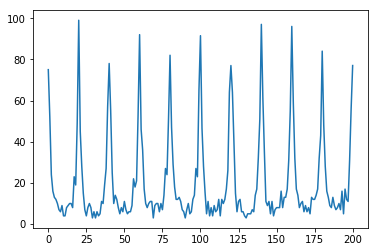

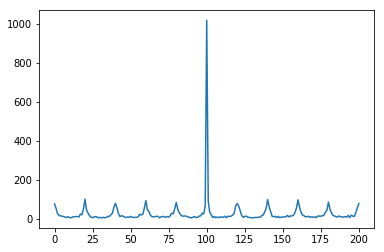

In [20]:
plt.plot(hist_corrected[3,8,:])
plt.show()
plt.plot((hist[3,8,:]))
#plt.plot(hist[12,8,:])
plt.show()

In [13]:
#min dead time calculation
for i in range(23):
    print(i,10*min(np.abs(100-np.where(hist_corrected[i,i,:]>0)[0])),'ns')

0 60 ns
1 60 ns
2 80 ns
3 60 ns
4 60 ns
5 80 ns
6 50 ns
7 80 ns
8 60 ns
9 70 ns
10 50 ns
11 60 ns
12 60 ns
13 70 ns
14 70 ns
15 100 ns
16 60 ns
17 70 ns
18 70 ns
19 60 ns
20 60 ns
21 80 ns
22 70 ns


In [738]:
#min dead time calculation
for i in range(23):
    print(i,10*min(np.abs(100-np.where(hist_corrected[i,i,:]>0)[0])),'ns')

0 90 ns
1 100 ns
2 140 ns
3 100 ns
4 100 ns
5 140 ns
6 80 ns
7 170 ns
8 100 ns
9 110 ns
10 80 ns
11 110 ns
12 100 ns
13 110 ns
14 110 ns
15 190 ns
16 110 ns
17 110 ns
18 130 ns
19 110 ns
20 100 ns
21 170 ns
22 140 ns


In [39]:
# Histogram array cretion
x_points = 11
y_points = 10
channels = 23
pixels = np.zeros((y_points,x_points))
scan_hist = np.zeros((y_points,x_points,channels)) 
lines = np.where(val_addr==31)[0]

if lines.shape ==(0,):
    lines = np.array([0,a])
else:
    lines =np.concatenate((lines,[a]))
for i in range(y_points):
    part = val_addr[lines[i]:lines[i+1]]
    pix = np.concatenate(([0],np.where(part==30)[0],[lines[i+1]-lines[i]]))
    print(pix)
    if i%2==0:
        pixels[i] = lines[i] + pix[:-1]
    else:
        pixels[i] = lines[i] + np.flip(pix[:-1])
    for j in range(x_points):
        scan_hist[i,j] = np.histogram(val_addr[lines[i]+pix[j]:lines[i]+pix[j+1]],bins=channels)[0]
    

[      0  116118  243848  372704  508168  632884  767103  892668 1018927
 1141854 1240041 1326924]
[      0   91332  202722  324569  456090  605562  745110  880085 1023049
 1171842 1299351 1428483]
[      0  143904  282706  416186  555620  695350  838734  988176 1128529
 1266155 1399300 1520285]
[      0  128687  266095  410040  562867  708671  859105 1004473 1161483
 1308648 1451115 1595553]
[      0  142094  303284  462339  626802  793457  949886 1109228 1255293
 1395528 1543824 1670079]
[      0  120416  252380  402132  561863  722442  868155 1051693 1204239
 1363118 1514990 1657646]
[      0  158426  307430  460157  623032  787623  952723 1115532 1280222
 1433702 1553207 1667459]
[      0  114187  251758  400034  540755  676509  839526 1008280 1164822
 1315487 1463864 1592976]
[      0  132550  263412  391047  545824  688147  842199  978435 1115604
 1251138 1378032 1502910]


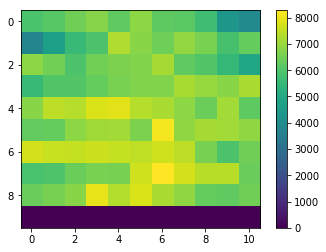

In [40]:
plt.imshow(scan_hist[:,:,0])
plt.colorbar()